Period: Pre-COVID


/var/folders/pc/lns8hzw16hl_1mkk28xvch5h0000gn/T/ipykernel_17488/2855516345.py:152: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_period = data[df['Period'] == period]


Data shape for Pre-COVID: (14339079, 14)
Train shape: (8603447, 13)
Validation shape: (2867816, 13)
Test shape: (2867816, 13)

--- Lasso Regression (Validation) ---
R²: 0.960, MSE: 94.565

--- Lasso Regression (Test) ---
R²: 0.961, MSE: 94.849

Lasso Coefficients:
                Feature  Coefficient
0                  year    -0.055329
1               quarter     0.000000
2                 month     0.000000
3     op_unique_carrier     0.071730
4             dep_delay     8.878145
5             dep_del15     2.936189
6          dep_time_blk     0.018559
7               flights     0.000000
8         carrier_delay    23.135629
9         weather_delay    10.777677
10            nas_delay    13.643169
11       security_delay     1.093250
12  late_aircraft_delay    18.707872





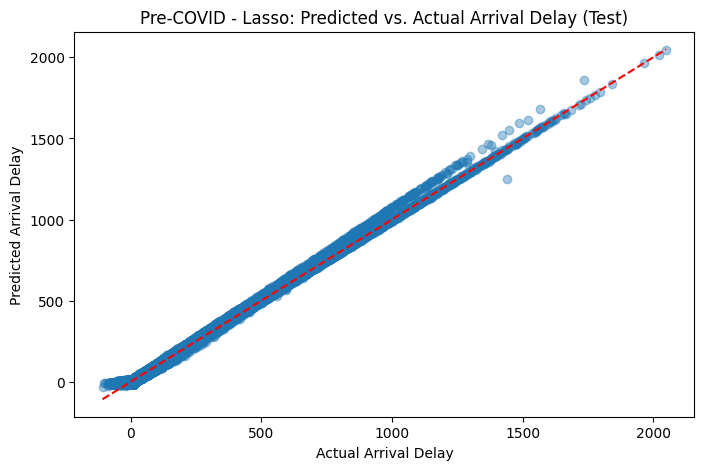

Period: COVID


/var/folders/pc/lns8hzw16hl_1mkk28xvch5h0000gn/T/ipykernel_17488/2855516345.py:152: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_period = data[df['Period'] == period]


Data shape for COVID: (4399575, 14)
Train shape: (2639745, 13)
Validation shape: (879915, 13)
Test shape: (879915, 13)

--- Lasso Regression (Validation) ---
R²: 0.923, MSE: 111.336

--- Lasso Regression (Test) ---
R²: 0.926, MSE: 111.343

Lasso Coefficients:
                Feature  Coefficient
0                  year     0.000000
1               quarter     0.483298
2                 month     0.203767
3     op_unique_carrier    -0.071047
4             dep_delay    16.359095
5             dep_del15     2.715944
6          dep_time_blk    -0.015401
7               flights     0.000000
8         carrier_delay    18.477666
9         weather_delay     8.599516
10            nas_delay    12.655320
11       security_delay     0.669409
12  late_aircraft_delay    14.934134





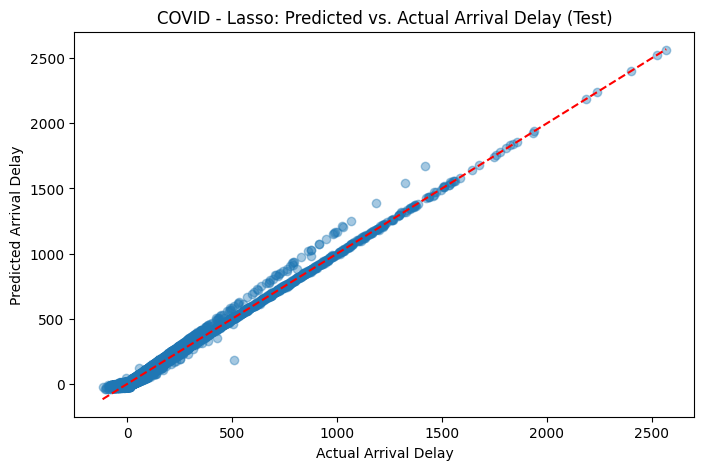

Period: Post-COVID


/var/folders/pc/lns8hzw16hl_1mkk28xvch5h0000gn/T/ipykernel_17488/2855516345.py:152: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_period = data[df['Period'] == period]


Data shape for Post-COVID: (5878219, 14)
Train shape: (3526931, 13)
Validation shape: (1175644, 13)
Test shape: (1175644, 13)

--- Lasso Regression (Validation) ---
R²: 0.960, MSE: 98.433

--- Lasso Regression (Test) ---
R²: 0.959, MSE: 98.816

Lasso Coefficients:
                Feature  Coefficient
0                  year     0.000000
1               quarter     0.053181
2                 month     0.514976
3     op_unique_carrier     0.102285
4             dep_delay    10.874622
5             dep_del15     2.855105
6          dep_time_blk     0.029446
7               flights     0.000000
8         carrier_delay    21.951673
9         weather_delay    10.226142
10            nas_delay    13.697795
11       security_delay     1.073955
12  late_aircraft_delay    17.682871





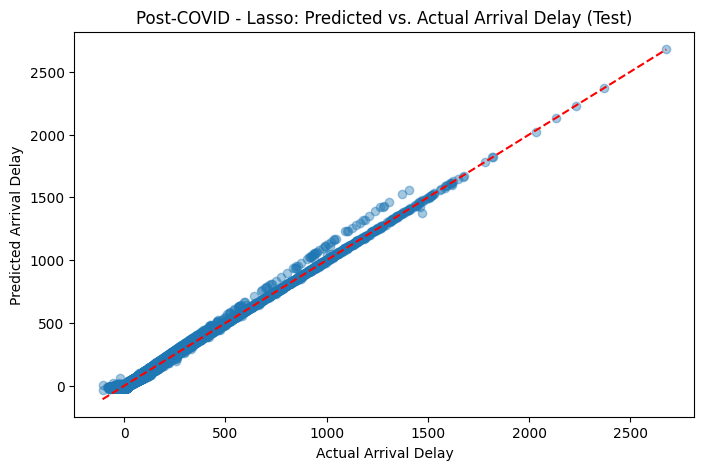

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Lasso   # Lasso is L1 regularized Linear Regression
from sklearn.metrics import r2_score, mean_squared_error

# Enable inline plotting (if using a Jupyter Notebook)
%matplotlib inline

# =============================================================================
# 1. Data Loading and Preprocessing
# =============================================================================

# Load the dataset (update the file path as necessary)
df = pd.read_csv('flights_jan_dec_all_years.csv')

# Convert the fl_date column to datetime.
# (Assuming the format is like "3/1/2019 12:00:00 AM")
df['fl_date'] = pd.to_datetime(df['fl_date'], format="%m/%d/%Y %I:%M:%S %p", errors='coerce')

# Ensure the year column is numeric.
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Create a new column for monthly aggregation based on fl_date.
df['year_month'] = df['fl_date'].dt.to_period('M').dt.to_timestamp()

# Filter data to include the years 2018, 2019, 2020, and 2021.
df = df[df['year'].isin([2018, 2019, 2020, 2021])]

# List of delay fields used in our analysis.
delay_fields = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

# Fill missing delay values with 0, assuming missing means no delay.
df[delay_fields] = df[delay_fields].fillna(0)

# =============================================================================
# 2. Assign Period Labels
# =============================================================================

def assign_period(year):
    if year == 2018 or year == 2019:
        return "Pre-COVID"
    elif year == 2020:
        return "COVID"
    elif year == 2021:
        return "Post-COVID"

df['Period'] = df['year'].apply(assign_period)

# =============================================================================
# 3. Feature Selection and Preparation for Regression Models
# =============================================================================

# Target variable: continuous arrival delay ("arr_delay")
target = 'arr_delay'

# Selected features (exclude those that may introduce circularity)
features = [
    'year', 'quarter', 'month', 'op_unique_carrier', 'dep_delay', 'dep_del15',
    'dep_time_blk', 'flights', 'carrier_delay', 'weather_delay', 'nas_delay', 
    'security_delay', 'late_aircraft_delay'
]

# Subset the data to selected features and the target. Drop rows with missing values.
data = df[features + [target]].dropna()

# Fill any remaining missing delay values with 0.
delay_columns = ['dep_delay', 'carrier_delay', 'weather_delay', 
                 'nas_delay', 'security_delay', 'late_aircraft_delay']
data[delay_columns] = data[delay_columns].fillna(0)

# Encode categorical features: 'op_unique_carrier' and 'dep_time_blk'
categorical_features = ['op_unique_carrier', 'dep_time_blk']
for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# Standardize numerical features (i.e., all features not in categorical_features)
numerical_features = [col for col in features if col not in categorical_features]
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# =============================================================================
# 4. Function to Split Data, Train Lasso Regressor, and Return Results
# =============================================================================

def split_and_train_lasso(data_subset, features, target, alpha=0.1):
    """
    Splits data_subset into train (60%), validation (20%), and test (20%) sets,
    fits a Lasso regression model with regularization parameter alpha,
    and returns the model performance (R² and MSE on validation and test sets),
    along with model coefficients and the data splits.
    """
    # Split into train_val (80%) and test (20%)
    X = data_subset[features]
    y = data_subset[target]
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, shuffle=True
    )
    # Split train_val into training (75% of 80% = 60% total) and validation (25% of 80% = 20% total)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=True
    )
    
    # ----- Lasso Regression (L1 Regularization) -----
    lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred_val = lasso.predict(X_val)
    r2_val = r2_score(y_val, y_pred_val)
    mse_val = mean_squared_error(y_val, y_pred_val)
    
    # Predict on test set
    y_pred_test = lasso.predict(X_test)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    # Package results and splits
    result = {
        'lasso': lasso,
        'r2_val': r2_val, 'mse_val': mse_val,
        'test_r2': test_r2, 'test_mse': test_mse,
        'coefficients': pd.DataFrame({
            'Feature': features,
            'Coefficient': lasso.coef_
        }),
        'X_train': X_train, 'y_train': y_train,
        'X_val': X_val, 'y_val': y_val,
        'X_test': X_test, 'y_test': y_test,
        'X_train_shape': X_train.shape, 'X_val_shape': X_val.shape, 'X_test_shape': X_test.shape
    }
    return result

# =============================================================================
# 5. Modeling for Each Period (Pre-COVID, COVID, Post-COVID) Using Lasso Regression
# =============================================================================

periods = ['Pre-COVID', 'COVID', 'Post-COVID']
results = {}

for period in periods:
    print("============================================")
    print(f"Period: {period}")
    
    # Subset data for the current period
    data_period = data[df['Period'] == period]
    print(f"Data shape for {period}: {data_period.shape}")
    
    # Only proceed if we have enough observations (e.g., more than 50)
    if data_period.shape[0] < 50:
        print(f"Not enough data for {period}; skipping.")
        continue
    
    # Split the data and train the Lasso model (with alpha = 0.1, you can tune this)
    result = split_and_train_lasso(data_period, features, target, alpha=0.1)
    results[period] = result
    
    # Print train/val/test shapes
    print("Train shape:", result['X_train_shape'])
    print("Validation shape:", result['X_val_shape'])
    print("Test shape:", result['X_test_shape'])
    
    # Print performance on validation set
    print("\n--- Lasso Regression (Validation) ---")
    print(f"R²: {result['r2_val']:.3f}, MSE: {result['mse_val']:.3f}")
    
    # Print performance on test set
    print("\n--- Lasso Regression (Test) ---")
    print(f"R²: {result['test_r2']:.3f}, MSE: {result['test_mse']:.3f}")
    
    # Display model coefficients (best features are those with non-zero coefficients)
    print("\nLasso Coefficients:")
    print(result['coefficients'])
    print("\n\n")
    
    # Optional: Plot predicted vs. actual for test set.
    y_test = result['y_test']
    y_pred_test = result['lasso'].predict(result['X_test'])
    
    plt.figure(figsize=(8, 5))
    plt.scatter(y_test, y_pred_test, alpha=0.4)
    plt.xlabel("Actual Arrival Delay")
    plt.ylabel("Predicted Arrival Delay")
    plt.title(f"{period} - Lasso: Predicted vs. Actual Arrival Delay (Test)")
    # Plot a 45° reference line
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.show()
